In [16]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_fscore_support)

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

# imbalance
from imblearn.over_sampling import SMOTE

import seaborn as sns
sns.set_theme()



#load dataset
df = pd.read_csv("/content/Loan_Default.csv")
print("Shape:", df.shape)
df.head()


Shape: (148670, 34)


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [17]:
# Target column
TARGET = "Status"

print("Target distribution:")
print(df[TARGET].value_counts())

# Check missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())

Target distribution:
Status
0    112031
1     36639
Name: count, dtype: int64

Missing values before cleaning:
ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score  

In [18]:
# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

# Remove target from categorical list
if TARGET in cat_cols:
    cat_cols.remove(TARGET)

# Fill numeric missing values with median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical missing values with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Missing values after cleaning:")
print(df.isnull().sum())

Missing values after cleaning:
ID                           0
year                         0
loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
LTV                          0
Region                       0
Security

In [19]:
from sklearn.preprocessing import LabelEncoder

# Encode target
le = LabelEncoder()
df[TARGET] = le.fit_transform(df[TARGET])

# One-hot encode categorical features
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("New shape after encoding:", df.shape)
df.head()

New shape after encoding: (148670, 51)


,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,...,age_45-54,age_55-64,age_65-74,age_<25,age_>74,submission_of_application_to_inst,Region_North-East,Region_central,Region_south,Security_Type_direct
0,24890,2019,116500,3.99,0.3904,2596.45,360.0,118000.0,1740.0,758,...,False,False,False,False,False,True,False,False,True,True
1,24891,2019,206500,3.99,0.3904,2596.45,360.0,418000.0,4980.0,552,...,False,True,False,False,False,True,False,False,False,True
2,24892,2019,406500,4.56,0.2000,595.00,360.0,508000.0,9480.0,834,...,False,False,False,False,False,True,False,False,True,True
3,24893,2019,456500,4.25,0.6810,2596.45,360.0,658000.0,11880.0,587,...,True,False,False,False,False,False,False,False,False,True
4,24894,2019,696500,4.00,0.3042,0.00,360.0,758000.0,10440.0,602,...,False,False,False,False,False,False,False,False,False,True


In [20]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (148670, 50)
y shape: (148670,)


In [29]:
# FIX COLUMN NAMES FOR XGBOOST
X.columns = (
    X.columns
    .str.replace('[', '', regex=False)
    .str.replace(']', '', regex=False)
    .str.replace('<', '', regex=False)
    .str.replace('>', '', regex=False)
    .str.replace('/', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

print("\nTrain target distribution:")
print(y_train.value_counts())

print("\nTest target distribution:")
print(y_test.value_counts())

Training set shape: (118936, 50)
Test set shape: (29734, 50)

Train target distribution:
Status
0    89625
1    29311
Name: count, dtype: int64

Test target distribution:
Status
0    22406
1     7328
Name: count, dtype: int64


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_features = X_train.select_dtypes(include=[np.number]).columns

# Fit only on X_train
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features]  = scaler.transform(X_test[numeric_features])

In [32]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_sm.value_counts().to_dict())

Before SMOTE: {0: 89625, 1: 29311}
After SMOTE: {0: 89625, 1: 89625}


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train distribution:", y_train.value_counts().to_dict())
print("Test distribution:", y_test.value_counts().to_dict())

Train distribution: {0: 89625, 1: 29311}
Test distribution: {0: 22406, 1: 7328}


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [35]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_sm.value_counts().to_dict())

Before SMOTE: {0: 89625, 1: 29311}
After SMOTE: {0: 89625, 1: 89625}


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC( kernel='linear',        # linear is MUCH faster than rbf
    max_iter=500,          # limits training time
    probability=True,
    class_weight='balanced',
    random_state=42
),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss'),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

In [37]:
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_sm, y_train_sm)
    trained_models[name] = model
    print(f"{name} — done.")


Training Logistic Regression...
Logistic Regression — done.
Training Naive Bayes...
Naive Bayes — done.
Training SVM...
SVM — done.
Training Decision Tree...
Decision Tree — done.
Training Random Forest...
Random Forest — done.
Training XGBoost...
XGBoost — done.
Training KNN...
KNN — done.


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []

for name, model in trained_models.items():
    print(f"\n===== {name} =====")

    y_pred = model.predict(X_test)

    # probability for ROC-AUC
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except:
        y_proba = None

    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred) * 100
    rec = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100
    auc = roc_auc_score(y_test, y_proba) * 100 if y_proba is not None else None

    # print nicely formatted with 2 decimals
    print(f"Accuracy: {acc:.2f}%")
    print(f"Precision: {prec:.2f}%")
    print(f"Recall: {rec:.2f}%")
    print(f"F1 Score: {f1:.2f}%")
    print(f"ROC-AUC: {auc:.2f}%" if auc is not None else "ROC-AUC: N/A")

    results.append([name, acc, prec, rec, f1, auc])



===== Logistic Regression =====
Accuracy: 83.38%
Precision: 65.09%
Recall: 70.21%
F1 Score: 67.56%
ROC-AUC: 85.53%

===== Naive Bayes =====
Accuracy: 87.97%
Precision: 100.00%
Recall: 51.20%
F1 Score: 67.73%
ROC-AUC: 100.00%

===== SVM =====
Accuracy: 26.55%
Precision: 25.06%
Recall: 99.52%
F1 Score: 40.04%
ROC-AUC: 65.76%

===== Decision Tree =====
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
ROC-AUC: 100.00%

===== Random Forest =====
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%
ROC-AUC: 100.00%

===== XGBoost =====
Accuracy: 99.98%
Precision: 99.93%
Recall: 100.00%
F1 Score: 99.97%
ROC-AUC: 100.00%

===== KNN =====
Accuracy: 90.27%
Precision: 73.87%
Recall: 93.64%
F1 Score: 82.59%
ROC-AUC: 96.61%


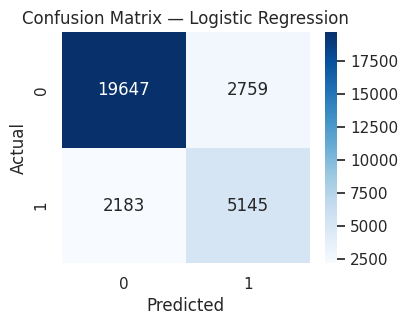

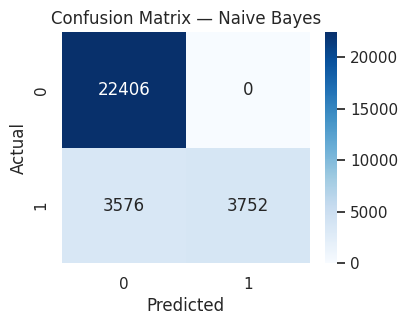

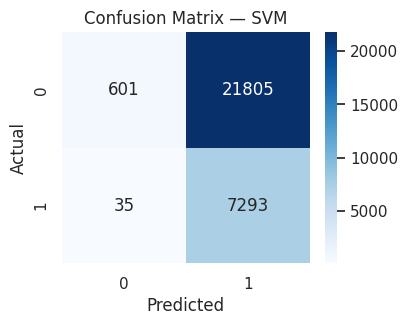

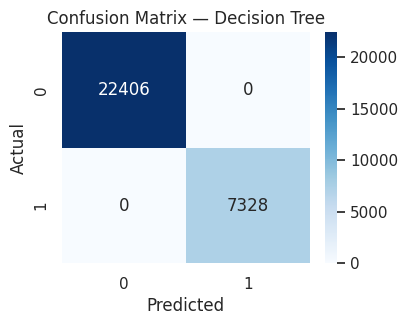

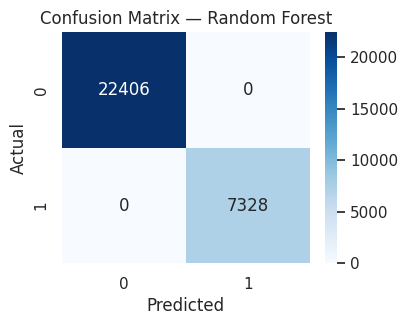

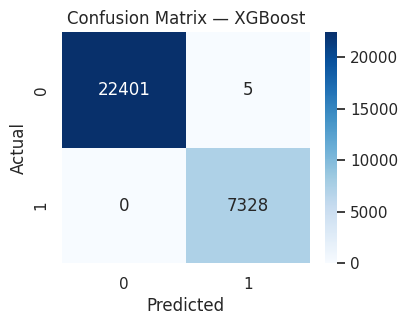

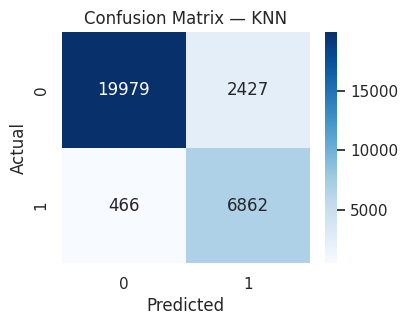

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

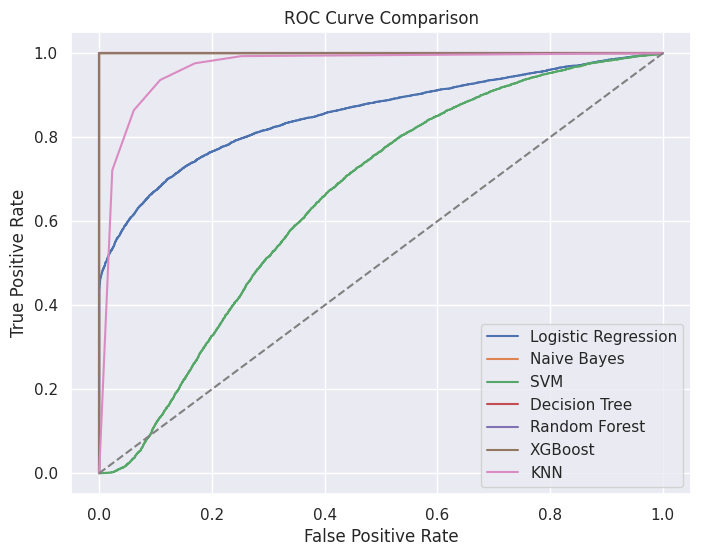

In [41]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

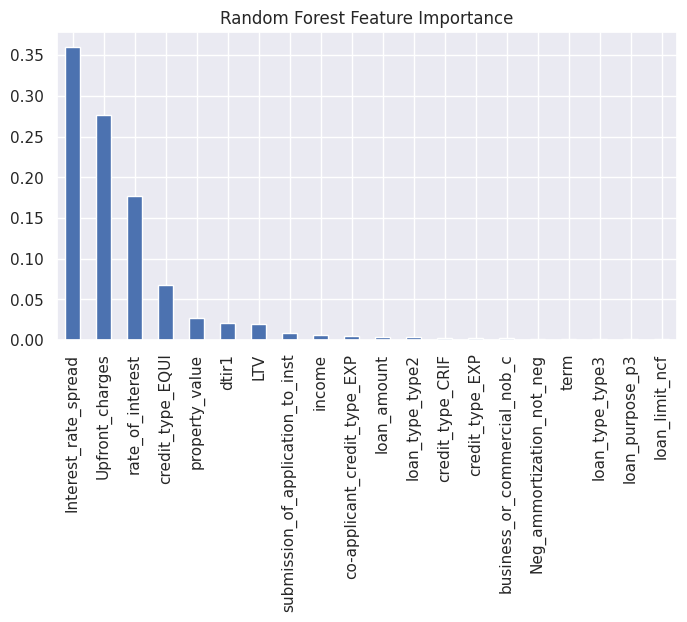

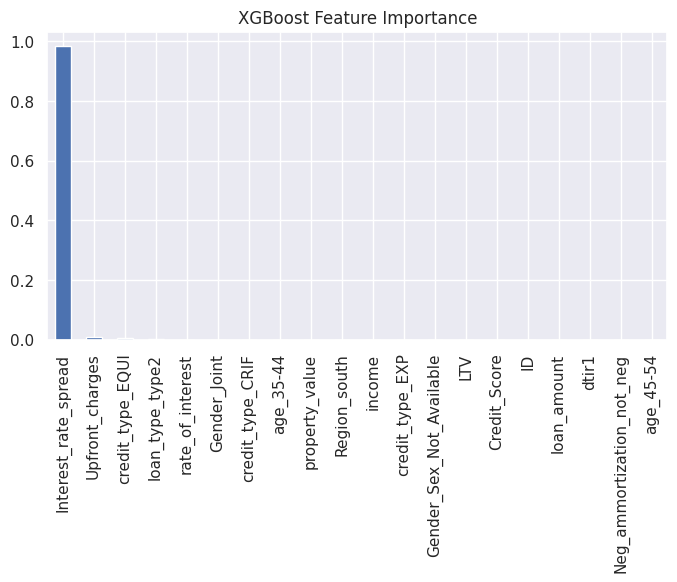

In [42]:
def plot_importances(model, title):
    if hasattr(model, "feature_importances_"):
        imp = pd.Series(model.feature_importances_, index=X.columns)
        imp.sort_values(ascending=False).head(20).plot(kind='bar', figsize=(8,4))
        plt.title(title)
        plt.show()

plot_importances(trained_models["Random Forest"], "Random Forest Feature Importance")
plot_importances(trained_models["XGBoost"], "XGBoost Feature Importance")

In [43]:
results_df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC"
])

results_df

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression,83.379296,65.093623,70.210153,67.555147,85.528517
1,Naive Bayes,87.973364,100.000000,51.200873,67.725632,99.999998
2,SVM,26.548732,25.063578,99.522380,40.042827,65.757677
3,Decision Tree,100.000000,100.000000,100.000000,100.000000,100.000000
4,Random Forest,100.000000,100.000000,100.000000,100.000000,100.000000
5,XGBoost,99.983184,99.931815,100.000000,99.965896,99.996955
6,KNN,90.270398,73.872322,93.640830,82.590119,96.606247
